In [1]:
import sys
sys.path.append("/Users/yzhiyuan/workspace/DENV_10X/notebook/") #enter the lib.util file directory
import lib.util
from lib.util import *

In [2]:
#pairwise pipeline for Yike
#functions for table generation
def get_cellind(adata):
    dic = {}
    for patient in adata.obs.ID.unique():
        if len(adata.obs.loc[adata.obs.ID == patient,:].index) >= 5:
            dic[patient] = list(adata.obs.loc[adata.obs.ID == patient,:].index)
    return dic

def exp_dic_gen (adata, cellind_dic):
    
    # initialize the dictionary
    dic = {}
    for patient in cellind_dic.keys():
        dic[patient] = pd.DataFrame(index = adata.var_names, columns = ['Avg_exp', 'Per_exp'])
    # calculate the mean and percentage of expression in each gene in each patient
#     n = 0
    for gene in adata.var_names:
        for patient in cellind_dic.keys():
            
            
            
            temp_array = np.squeeze(np.asarray(adata[cellind_dic[patient], gene].X.todense()))
            dic[patient].loc[gene, 'Avg_exp'] = temp_array.mean()
            
#             print (dic[patient].loc[gene, 'Avg_exp'])
#             print(dic[patient].loc['AL627309.1', 'Avg_exp'])
#             print(gene)
#             print(patient)

            
            dic[patient].loc[gene, 'Per_exp'] = len(np.flatnonzero(temp_array)) / len(temp_array)
        
#         n = n + 1
#         if n > 1:
#             break
    return (dic)

#clean the dictionary to exclude genes that low expressed across all patients.
def clean_dic (dic, cutoff):
    dic_gene = {}
    for patient in dic.keys():
        dic_gene[patient] = list(dic[patient].loc[dic[patient].Per_exp > cutoff,:].index)
    gene_list = []
    for patient in dic_gene.keys():
        temp_list = [gene for gene in dic_gene[patient] if gene not in gene_list]
        gene_list.extend(temp_list)
    dic_clean = {}
    for patient in dic.keys():
        dic_clean[patient] = dic[patient].loc[gene_list,:]
    return(dic_clean, gene_list)


#generate pairwise table
import random
def pairwise_table_gen(adata, iteration, cellind_dic):
    
    patients_ID = list(cellind_dic.keys())
    
    D_group = [x for x in patients_ID if x in (list(adata.obs.loc[adata.obs.Condition == 'dengue',:].ID.unique()))]
    SD_group = [x for x in patients_ID if x in (list(adata.obs.loc[adata.obs.Condition == 'S_dengue',:].ID.unique()))]
    df = pd.DataFrame(index = np.arange(iteration), columns = ['D_group', 'SD_group'])
    for i in np.arange(iteration):
        df.loc[i, 'D_group'] = random.sample(D_group, 1)[0]
        df.loc[i, 'SD_group'] = random.sample(SD_group, 1)[0]
    return(df)

def pairwise_compare(dic, table, genelist):
    final_dic = {}
    for key_name in ['Avg_exp', 'Per_exp']:
        df = pd.DataFrame(index = genelist, columns = table.index)
        for i in table.index:
            id_SD = table.loc[i, 'SD_group']
            id_D = table.loc[i, 'D_group']
            df.loc[:,i] = dic[id_SD].loc[:,key_name] - dic[id_D].loc[:,key_name]
        final_dic[key_name] = df
    return(final_dic)

def table_gen_final(adata, gene_cut_off, compare_number, save_path, filename):
    cellind_dic = get_cellind(adata)
    exp_dic = exp_dic_gen(adata, cellind_dic)
    dic_clean, genelist = clean_dic (exp_dic, gene_cut_off)
    pariwise_table = pairwise_table_gen(adata, compare_number, cellind_dic)
    final_dic = pairwise_compare(dic_clean, pariwise_table, genelist)
    
    Avg = 'pairwise_Avg_'+filename+'.tsv'
    Per = 'pairwise_Per_'+filename+'.tsv'
    table = 'pairwise_table_'+filename+'.tsv'
    
    final_dic['Avg_exp'].to_csv(os.path.join(save_path, Avg), sep = '\t')
    final_dic['Per_exp'].to_csv(os.path.join(save_path, Per), sep = '\t')
    pariwise_table.to_csv(os.path.join(save_path, table), sep = '\t')
    
    return(pariwise_table, final_dic)

In [23]:
#functions for plotting
def df_processing_2(df):
    temp_df = pd.DataFrame(index = df.index, columns = ['median', '25_quantile', '75_quantile', 
                                                        'positive_values_count'])
    temp_df['median'] = df.median(axis = 1)
    temp_df['25_quantile'] = df.quantile(q=0.25, axis = 1)
    temp_df['75_quantile'] = df.quantile(q=0.75, axis = 1)
    temp_df['positive_values_count'] = df.gt(0).sum(axis = 1)
    for gene in temp_df.index:
        temp_df.loc[gene,'gene'] = gene + '({}/50)'.format(temp_df.loc[gene,'positive_values_count'])
    temp_df = temp_df.sort_values(by = 'positive_values_count', ascending  = False)
    return(temp_df)

def merge_kid_adult(df_kid, df_adult):
    intersect = [x for x in df_kid.index if x in df_adult.index]
    df_adult.columns = ['median_a', '25_quantile_a', '75_quantile_a', 'positive_values_count_a', 'gene_a']
    df = pd.concat([df_kid.loc[intersect, :], df_adult.loc[intersect, :]], axis=1)
    return(df)

def df_merge_processing(df_merge):
    ind_kid = df_merge.loc[(df_merge['positive_values_count'] >= 35) | (df_merge['positive_values_count'] <= 15),:].index
    ind_adult = df_merge.loc[(df_merge['positive_values_count_a'] >= 35) | (df_merge['positive_values_count_a'] <= 15),:].index
    ind_merge = [x for x in ind_kid if x in ind_adult]
    df_merge['outlier'] = 'no'
    df_merge.loc[ind_kid, 'outlier'] = 'kid_only'
    df_merge.loc[ind_adult, 'outlier'] = 'adult_only'
    df_merge.loc[ind_merge, 'outlier'] = 'both'
    
    x_mean = df_merge['median'].mean()
    y_mean = df_merge['median_a'].mean()
    df_merge['distance'] = np.sqrt((df_merge['median'] - x_mean)**2 + (df_merge['median_a'] - y_mean)**2)
    df_merge['distance_x'] = df_merge['median'] - x_mean
    df_merge['distance_y'] = df_merge['median_a'] - y_mean
    
    df_merge_2 = df_merge[df_merge.distance >= df_merge.distance.quantile(q = 0.95)]
    radius = df_merge_2.sort_values(by = 'distance').iloc[0, 11]
#     df_merge_2 = df_merge_2.loc[(df_merge_2.distance_x > 1) | (df_merge_2.distance_x < -1)]
    
    markers_1 = df_merge_2.loc[(df_merge_2['distance_x'] > 1) & (df_merge_2['distance_y'] > -1)].index
    markers_2 = df_merge_2.loc[(df_merge_2['distance_x'] < -1) & (df_merge_2['distance_y'] > -1)].index
    markers_3 = df_merge_2.loc[(df_merge_2['distance_x'] > 1) & (df_merge_2['distance_y'] < -1)].index
    markers_4 = df_merge_2.loc[(df_merge_2['distance_x'] < -1) & (df_merge_2['distance_y'] < -1)].index
    
    
    df_merge['markers'] = 'no'
    df_merge.loc[markers_1, 'markers'] = '1'
    df_merge.loc[markers_2, 'markers'] = '2'
    df_merge.loc[markers_3, 'markers'] = '3'
    df_merge.loc[markers_4, 'markers'] = '4'
    
    return(df_merge, radius)

    
#for plotting numebers out of 50 comparisons    
def pairwise_barplot(df_origin, df_merge, path, filetype, name = 'kid'):
    rcParams['figure.figsize']=(14, 26)
    rcParams['font.size']=18
    rcParams['pdf.fonttype'] = 42
    
    temp = df_merge.loc[df_merge.markers != 'no']
    temp = temp.sort_values(by = 'markers', ascending = True)
    gene_list = temp.index
    
    data = df_origin.copy()
    data = data.loc[gene_list,:]
    
    data['markers'] = df_merge.loc[gene_list, 'markers']
    
    if name == 'kid':
        data.index = temp.loc[gene_list, 'gene']
    else:
        data.index = temp.loc[gene_list, 'gene_a']
    
    data['gene'] = data.index
    data_2 = pd.melt(data, id_vars = ['markers', 'gene'])
    
    fig, ax = plt.subplots()
    ax = sb.boxplot(data = data_2, x = 'value', y = 'gene', hue = 'markers', orient = 'h',
                   palette = ['purple', 'orange', 'blue', 'red'])
    ax.set_xlabel('diff_log2(cpm)')
    ax.set_title(name)
    ax.get_legend().remove()
    ax.set_xlim(-9,9)
    filename = name + '.' + filetype

    fig.savefig(os.path.join(path, filename),
               bbox_inches='tight')
    

import matplotlib as mpl

def scatter_pairwise_2(df_merge, radius, marklist, path, name, filetype):
    fig, ax = plt.subplots()
    rcParams['figure.figsize']=(16, 16)
    rcParams['font.size']=18
    rcParams['pdf.fonttype'] = 42
    
    sb.scatterplot(x = 'median', y = 'median_a', data = df_merge, ax = ax, hue = 'markers', 
                   palette = ['red','grey', 'blue', 'purple', 'orange'], edgecolor=None)
    
    sb.kdeplot(x = 'median', y = 'median_a', data = df_merge.loc[:,['median', 'median_a']], ax = ax)
    
    x_mean = df_merge['median'].mean()
    y_mean = df_merge['median_a'].mean()
    ax.axvline(x=x_mean, ls = '--', c = 'black', lw = 2)
    ax.axhline(y=y_mean, ls = '--', c = 'black', lw = 2)
    
#     df_temp = df_merge[df_merge.markers != 'no']
    mark_list = marklist
    for gene in mark_list:
        ax.text(df_merge.loc[gene, 'median']-0.6, 
        df_merge.loc[gene, 'median_a'] + 0.005,
        gene, color = 'black',
        fontsize = 14)
        
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
# Draw 8 slices using Fabio's function  
    draw_8_slices(ax, (x_mean, y_mean), radius=radius)
    ax.set_xlabel('log2fold_change_kid')
    ax.set_ylabel('log2fold_change_adult')
    
    ax.set_title('SD vs D')
    ax.get_legend().remove()
    
    filename = name + '.' + filetype
    fig.savefig(os.path.join(path, filename), bbox_inches = 'tight')
    
    
#Fabio's function
def draw_8_slices(ax, center, radius=1.0):
    def cp(amin, amax, center, ndots=100):
            xc, yc = center
            angles = np.linspace(amin, amax, ndots)
            xcircs, ycircs = xc + radius * np.cos(angles), yc + radius * np.sin(angles)
            return [(xi, yi) for xi, yi in zip(xcircs, ycircs)][::-1]

    def draw_wedge(ax, points, color):
            points = np.array(points)
            center = points.mean(axis=0)
            delta = points - center
            points = center + 0.99 * delta

            rgb = list(mpl.colors.to_rgba(color)[:-1])
            rgba_edge = tuple(rgb + [0.6])
            rgba_fill = tuple(rgb + [0.2])
            ax.add_artist(plt.Polygon(
                points, edgecolor=rgba_edge, facecolor=rgba_fill, lw=2,
                clip_on=False,
                ))

    xc, yc = center
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    # Cross
    ax.axvline(xc, ls='--', color='k')
    ax.axhline(yc, ls='--', color='k')

    # Circle
    rgb = list(mpl.colors.to_rgba('grey'))[:-1]
    circle = plt.Circle(center, radius, facecolor=tuple(rgb + [0.2]), edgecolor='k')
    ax.add_artist(circle)

    # Wedges
    # 1. intersections with circle
#     angles = 2 * np.pi / 8 * (np.arange(8) + 0.5)

    angles = np.array([np.arcsin(1/radius), np.arccos(1/radius), np.pi-np.arccos(1/radius), np.pi - np.arcsin(1/radius),
                               np.pi+np.arcsin(1/radius), np.pi+np.arccos(1/radius), 2*np.pi-np.arccos(1/radius), 2*np.pi-np.arcsin(1/radius)])
    
    
#     xcircs = np.array([np.sqrt(radius**2 - 1), 1, -1, -np.sqrt(radius**2 - 1), 
#                        -np.sqrt(radius**2 - 1), -1, 1, np.sqrt(radius**2 - 1)]) - xc
#     ycircs = np.array([1, np.sqrt(radius**2 - 1), np.sqrt(radius**2 - 1), 1, 
#                        -1, -np.sqrt(radius**2 - 1), -np.sqrt(radius**2 - 1), -1]) - yc
    
    xcircs, ycircs = xc + radius * np.cos(angles), yc + radius * np.sin(angles)
    circs = np.vstack([xcircs, ycircs]).T
    # 2. Intersections with axes border
    xbords, ybords = [], []
    xbords.append(xmax)
    ybords.append(yc + 1)
    xbords.append(xc + 1)
    ybords.append(ymax)
    xbords.append(xc - 1)
    ybords.append(ymax)
    xbords.append(xmin)
    ybords.append(yc + 1)
    xbords.append(xmin)
    ybords.append(yc - 1)
    xbords.append(xc - 1)
    ybords.append(ymin)
    xbords.append(xc + 1)
    ybords.append(ymin)
    xbords.append(xmax)
    ybords.append(yc - 1)

    bords = np.vstack([xbords, ybords]).T

    # 3. draw wedges
    draw_wedge(ax, [circs[0], bords[0], (xmax, ymax), bords[1], circs[1]] + cp(angles[0], angles[1], center), color='purple')
    draw_wedge(ax, [circs[1], bords[1], bords[2], circs[2]] + cp(angles[1], angles[2], center), color='grey')
    draw_wedge(ax, [circs[2], bords[2], (xmin, ymax), bords[3], circs[3]] + cp(angles[2], angles[3], center), color='dodgerblue')
    draw_wedge(ax, [circs[3], bords[3], bords[4], circs[4]] + cp(angles[3], angles[4], center), color='lawngreen')
    draw_wedge(ax, [circs[4], bords[4], (xmin, ymin), bords[5], circs[5]] + cp(angles[4], angles[5], center), color='orange')
    draw_wedge(ax, [circs[5], bords[5], bords[6], circs[6]] + cp(angles[5], angles[6], center), color='grey')
    draw_wedge(ax, [circs[6], bords[6], (xmax, ymin), bords[7], circs[7]] + cp(angles[6], angles[7], center), color='tomato')
    draw_wedge(ax, [circs[7], bords[7], bords[0], circs[0]] + cp(angles[7], 2*np.pi+angles[0], center), color='pink')
    
    
    
    
    
def pairwise_barplot_top2(df_origin, df_merge, gene_list, path, filetype, name = 'kid'):
    rcParams['font.size']=18
    rcParams['pdf.fonttype'] = 42
    
    temp = df_merge.loc[df_merge.markers != 'no']
    temp = temp.sort_values(by = 'markers', ascending = True)
    
    data = df_origin.copy()
    data = data.loc[gene_list,:]
    
    data['markers'] = df_merge.loc[gene_list, 'markers']
    
#     if name == 'kid':
#         data.index = temp.loc[gene_list, 'gene']
#     else:
#         data.index = temp.loc[gene_list, 'gene_a']
    
    data['gene'] = data.index
    data_2 = pd.melt(data, id_vars = ['markers', 'gene'])
    
    fig, ax = plt.subplots()
    ax = sb.boxplot(data = data_2, x = 'value', y = 'gene', hue = 'markers', orient = 'h',
                   palette = ['purple', 'orange', 'red', 'blue'])
    ax.axvline(x = 0, ls = '--', lw = 2, c = 'black')
    
    ax.set_xlabel('diff_log2(cpm)')
    ax.set_title(name)
    ax.get_legend().remove()
    ax.set_xlim(-9,9)
    filename = name + '.' + filetype

    fig.savefig(os.path.join(path, filename),
               bbox_inches='tight')

In [4]:
#initiate the dataset, select monocytes in kids only
path = '/Users/yzhiyuan/workspace/DENV_10X/PythonProject/PNAS_10X/mergedata_20210519.loom'
adata = getdata(path)
adata_kid = subsetdata(adata)
adata_kid = normalizedata(adata_kid)
adata_kid = removegenes(adata_kid)

adata_kid_M = adata_kid[adata_kid.obs.cell_type == 'Monocytes']
adata_kid_M = removegenes(adata_kid_M)
sc.pp.filter_genes(adata_kid_M, min_cells=3)

In [6]:
#table generation for kids
path = '/Users/yzhiyuan/workspace/DENV_10X/tables/test/'
filename = 'kid_m'
pariwise_table_M, final_dic_M = table_gen_final(adata_kid_M, 0.1, 50, path, filename)

In [7]:
#initiate the dataset, select monocytes in adult only
adata_adult = subsetdata(adata, platform ='plate')
adata_adult = normalizedata(adata_adult)
adata_adult = removegenes(adata_adult)

adata_adult_M = adata_adult[adata_adult.obs.cell_type == 'Monocytes']
adata_adult_M = removegenes(adata_adult_M)
sc.pp.filter_genes(adata_adult_M, min_cells=3)

In [8]:
#table generation for adults
path = '/Users/yzhiyuan/workspace/DENV_10X/tables/test/'
filename = 'adult_M'
pariwise_table_a, final_dic_adult_M = table_gen_final(adata_adult_M, 0.1, 50, path, filename)

In [10]:
#load the dataframe from children and adult
df = final_dic_M['Avg_exp']
df_a = final_dic_adult_M['Avg_exp']


In [11]:
#merge kid and adult tables and calculate the radius

df_kid = df_processing_2(df)
df_adult = df_processing_2(df_a)
df_merge = merge_kid_adult(df_kid, df_adult)
df_merge_2, radius = df_merge_processing(df_merge)

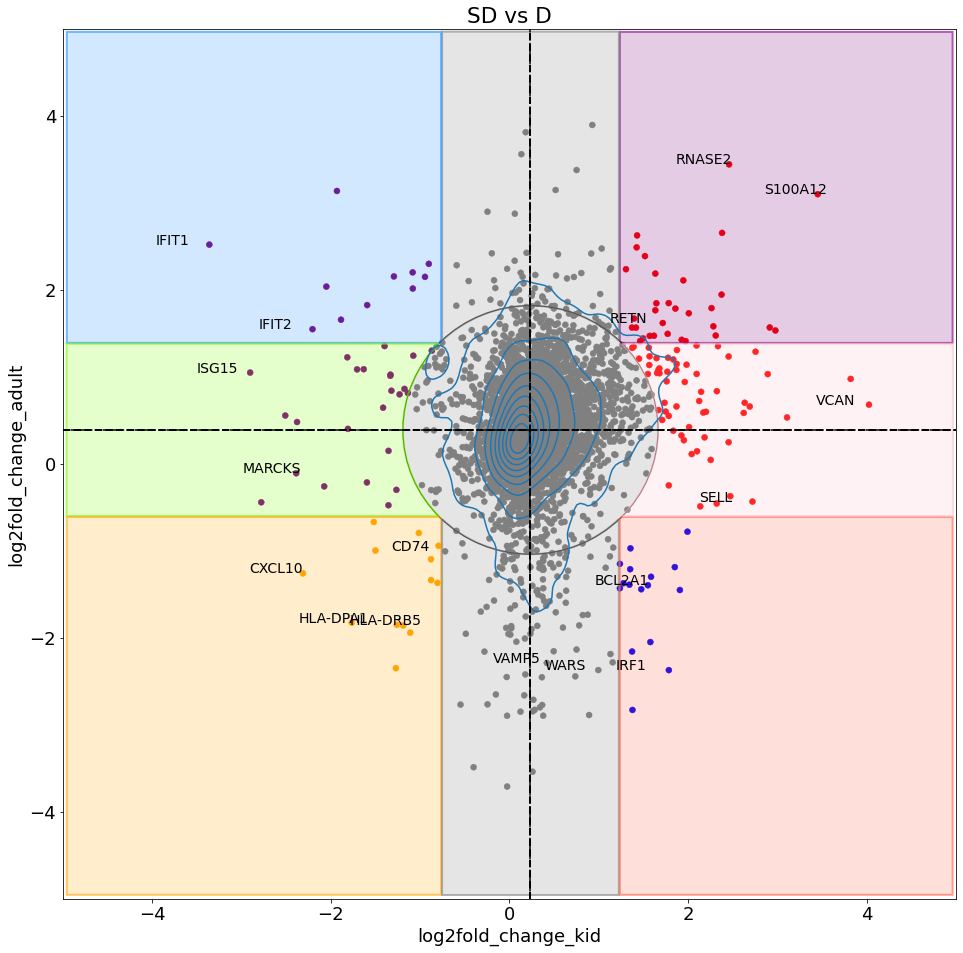

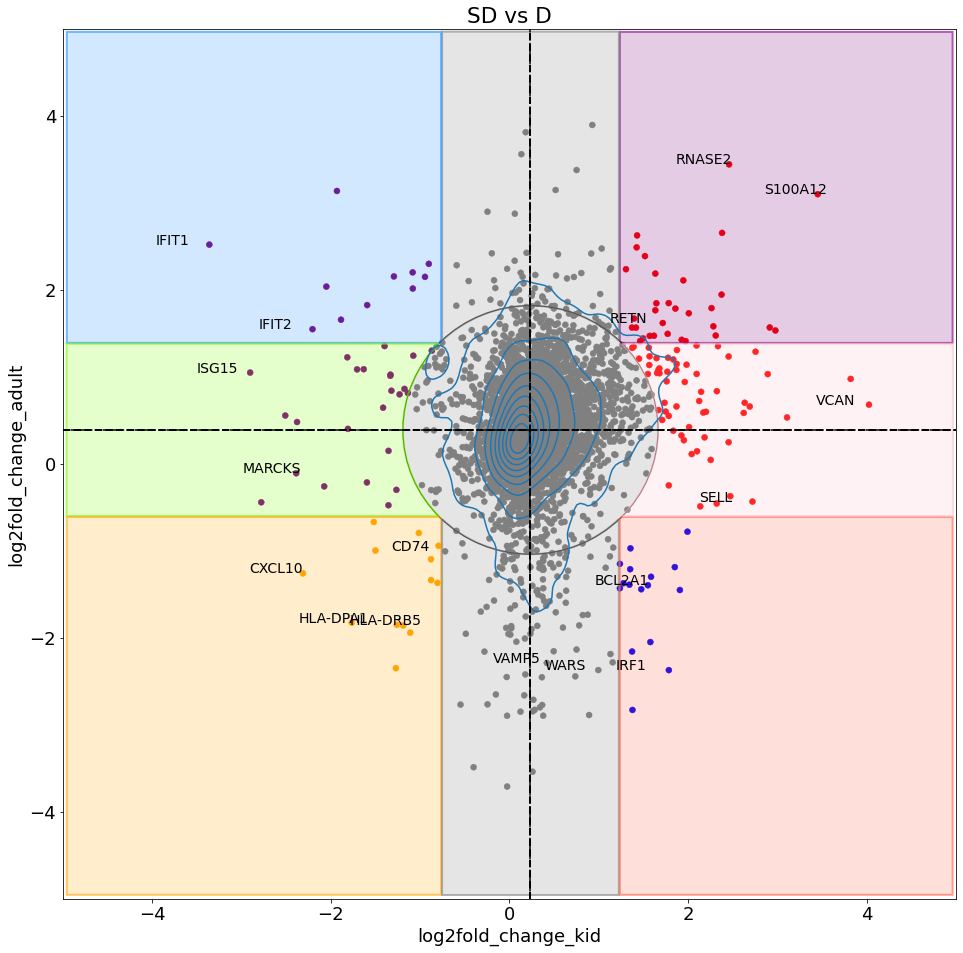

In [24]:
#plotting 2D plot
marklist = ['IFIT1', 'IFIT2', 'ISG15', 'MARCKS', 'CXCL10', 
                 'HLA-DPA1', 'HLA-DRB5', 'CD74', 'RNASE2', 'S100A12', 'SELL', 'VCAN', 'RETN', 'IRF1', 'BCL2A1', 'WARS', 'VAMP5'] 
path = '/Users/yzhiyuan/workspace/DENV_10X/tables/test/'
name = 'scatter_pairwise'
rcParams['figure.figsize']=(16, 16)
scatter_pairwise_2(df_merge_2, radius, marklist, path, name, 'png')
scatter_pairwise_2(df_merge_2, radius, marklist, path, name, 'pdf')

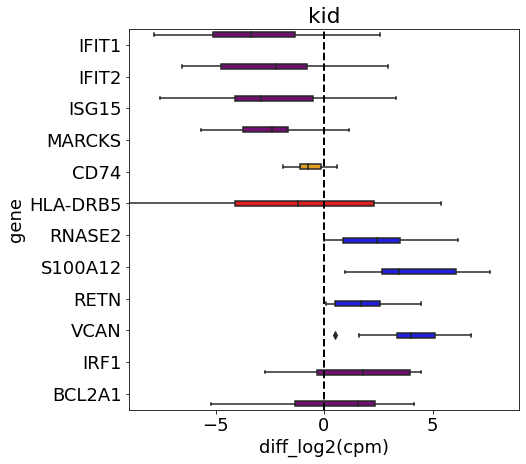

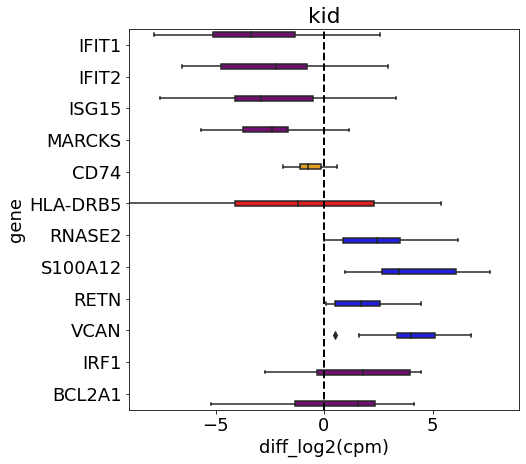

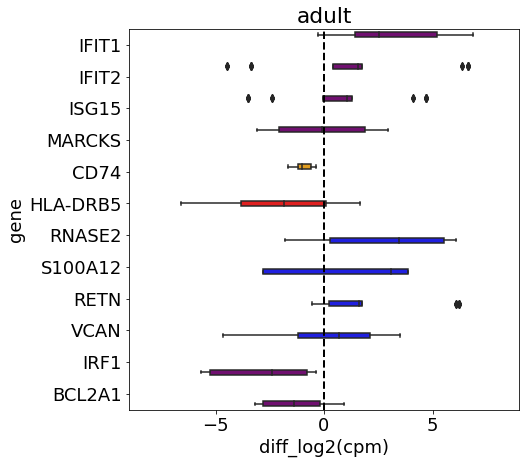

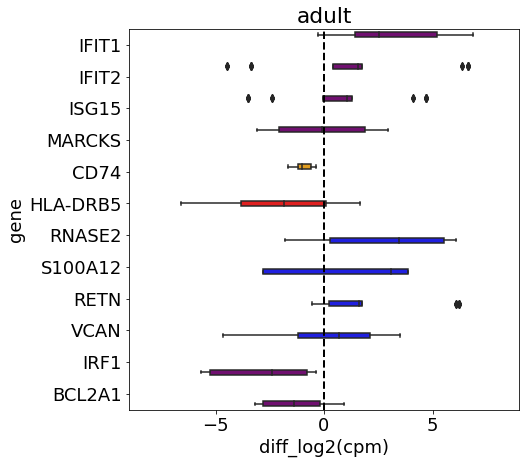

In [25]:
#plotting bar plot

gene_list = ['IFIT1', 'IFIT2', 'ISG15', 'MARCKS', 'CD74', 
                 'HLA-DRB5', 'RNASE2', 'S100A12', 'RETN', 'VCAN', 'IRF1', 'BCL2A1'] 
path = '/Users/yzhiyuan/workspace/DENV_10X/tables/test/'
rcParams['figure.figsize']=(7, 7)

pairwise_barplot_top2(df, df_merge, gene_list, path, 'png', name = 'kid')
pairwise_barplot_top2(df, df_merge, gene_list, path, 'pdf', name = 'kid')
pairwise_barplot_top2(df_a, df_merge, gene_list, path, 'png', name = 'adult')
pairwise_barplot_top2(df_a, df_merge, gene_list, path, 'pdf', name = 'adult')